# **Musculoskeletal Radiographs Abnormality Detection**

# **Exploratory Data Analysis**

### **Problem**

Determining whether a radiographic study is normal or abnormal is a critical radiological task: a study interpreted as normal rules out disease and can eliminate the need for patients to undergo further diagnostic procedures or interventions. The musculoskeletal abnormality detection task is particularly critical as more than 1.7 billion people are affected by musculoskeletal conditions worldwide (BMU, 2017). These conditions are the most common cause of severe, long-term pain and disability (Woolf & Pfleger, 2003), with 30 million emergency department visits annually and increasing. Our dataset, MURA, contains 9,045 normal and 5,818 abnormal musculoskeletal radiographic studies of the upper extremity including the shoulder, humerus, elbow, forearm, wrist, hand, and finger. MURA is one of the largest public radiographic image datasets. More information about the  the dataset can be found [here](http://stanfordmlgroup.github.io/competitions/mura/)  as well as [in this paper](http://https://arxiv.org/pdf/1712.06957.pdf)

In [1]:
%%bash
pip install keras-adabound
pip install tensorflow_addons

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for keras-adabound: filename=keras_adabound-0.6.0-py3-none-any.whl size=6607 sha256=46378048b6efab9a27e921cf5af557dc6c2e39864e694c857617651c1ace6878
  Stored in directory: /root/.cache/pip/wheels/3e/bf/39/3d95847ef12aa58c15a6cc7a20f4f21ea39fcd52793e1beea0
Successfully built keras-adabound


In [2]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from enum import Enum
import cv2
from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)
import gc
from tensorflow.keras.utils import to_categorical
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD, Adam
from keras_adabound import AdaBound
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Input, Conv2D,BatchNormalization
from tensorflow.keras.layers import Activation,SpatialDropout2D,AvgPool2D
from tensorflow.keras.layers import MaxPool2D,Dropout,GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D,Flatten,Dropout,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from tensorflow_addons.metrics import CohenKappa
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications import DenseNet121,DenseNet169,DenseNet201
from tensorflow.keras.models import load_model
from numpy import dstack
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50

In [3]:
# define seed number to have reproducible experiments.
seed = 3352024
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

# Load data

This data comes as split dataset (training & validation in separate directories). Each data categories such as training & validation has sub-directories (pls see below).


```

└─train {data category}
│   └───XR_ELBOW {study type}
│       │  └───patient00011 {patient}
│       │         └───study1_negative {study with label}
│       │               └───image1.png {radiographs}
│       │               └───image2.png 
│       │               └───image3.png 
                        └───...
   ...
   

└─valid {data category}
│   └───XR_HUMERUS {study type}
│       │  └───patient11216 {patient}
│       │         └───study1_negative {study with label}
│       │               └───image1.png {radiographs}
│       │               └───image2.png 
                        └───...
```

**Load dataset**

In [4]:
def load_path(path):
    
    '''
    load MURA dataset
    '''
    dataset = [] 
    for body in os.listdir(path):
        body_part = body
        path_p = path+'/'+str(body)
        for id_p in os.listdir(path_p):
            patient_id = id_p
            path_id = path_p+'/'+str(id_p)
            for lab in os.listdir(path_id):
                if lab.split('_')[-1]=='positive': 
                    label = 1 
                elif lab.split('_')[-1]=='negative':
                    label= 0
                path_l = path_id+'/'+str(lab)
                for img in os.listdir(path_l):  
                    img_path = path_l + '/' + str(img)
                    dataset.append(
                        {
                            'body_part': body_part,
                            'patient_id': patient_id,
                            'label': label,
                            'img_path': img_path
                        }
                    )
    return dataset

In [5]:
path = '../input/mura-v11/MURA-v1.1/train'
os.listdir(path)

['XR_WRIST',
 'XR_FINGER',
 'XR_SHOULDER',
 'XR_HAND',
 'XR_FOREARM',
 'XR_HUMERUS',
 'XR_ELBOW']

**Train set**

In [6]:
dataset = load_path(path)
df_train = pd.DataFrame(dataset)
df_train.head()

,body_part,patient_id,label,img_path
0,XR_WRIST,patient07547,0,../input/mura-v11/MURA-v1.1/train/XR_WRIST/pat...
1,XR_WRIST,patient07547,0,../input/mura-v11/MURA-v1.1/train/XR_WRIST/pat...
2,XR_WRIST,patient07547,0,../input/mura-v11/MURA-v1.1/train/XR_WRIST/pat...
3,XR_WRIST,patient07547,0,../input/mura-v11/MURA-v1.1/train/XR_WRIST/pat...
4,XR_WRIST,patient07547,0,../input/mura-v11/MURA-v1.1/train/XR_WRIST/pat...


In [7]:
dataset_test = load_path(path = '../input/mura-v11/MURA-v1.1/valid')
df_test = pd.DataFrame(dataset_test)
df_test.head()

,body_part,patient_id,label,img_path
0,XR_WRIST,patient11268,1,../input/mura-v11/MURA-v1.1/valid/XR_WRIST/pat...
1,XR_WRIST,patient11268,1,../input/mura-v11/MURA-v1.1/valid/XR_WRIST/pat...
2,XR_WRIST,patient11268,1,../input/mura-v11/MURA-v1.1/valid/XR_WRIST/pat...
3,XR_WRIST,patient11302,0,../input/mura-v11/MURA-v1.1/valid/XR_WRIST/pat...
4,XR_WRIST,patient11380,0,../input/mura-v11/MURA-v1.1/valid/XR_WRIST/pat...


**Training set**

In [8]:
#csv files path
path = '../input/mura-v11/MURA-v1.1'
train_image_paths_csv = "train_image_paths.csv"

In [9]:
train_images_paths = pd.read_csv(os.path.join(path,train_image_paths_csv),dtype=str,header=None)
train_images_paths.columns = ['image_path']

In [10]:
train_images_paths['label'] = train_images_paths['image_path'].map(lambda x:'positive' if 'positive' in x else 'negative')
train_images_paths['category']  = train_images_paths['image_path'].apply(lambda x: x.split('/')[2])  
train_images_paths['patientId']  = train_images_paths['image_path'].apply(lambda x: x.split('/')[3].replace('patient',''))
train_images_paths.head()

,image_path,label,category,patientId
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive,XR_SHOULDER,00002
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive,XR_SHOULDER,00002


**Test set**

In [11]:
path = '../input/mura-v11/MURA-v1.1'
valid_image_paths_csv = "valid_image_paths.csv"
valid_data_paths = pd.read_csv(os.path.join(path,valid_image_paths_csv),dtype=str,header=None)
valid_data_paths.columns = ['image_path']

In [12]:
valid_data_paths['label'] = valid_data_paths['image_path'].map(lambda x:'positive' if 'positive' in x else 'negative')
valid_data_paths['category']  = valid_data_paths['image_path'].apply(lambda x: x.split('/')[2])  
valid_data_paths['dir'] =  valid_data_paths['image_path'].apply(lambda x: x.split('/')[1])
valid_data_paths['patientId']  = valid_data_paths['image_path'].apply(lambda x: x.split('/')[3].replace('patient',''))
valid_data_paths.head()

,image_path,label,category,dir,patientId
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,positive,XR_WRIST,valid,11186


In [13]:
train_images_paths['label_index']= train_images_paths.label

In [14]:
train_images_paths.label_index.replace('positive', 1, inplace=True)
train_images_paths.label_index.replace('negative', 0, inplace=True)
train_images_paths.head(3)

,image_path,label,category,patientId,label_index
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001,1
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001,1
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001,1


In [15]:
valid_data_paths['label_index']= valid_data_paths.label
valid_data_paths.label_index.replace('positive', 1, inplace=True)
valid_data_paths.label_index.replace('negative', 0, inplace=True)
valid_data_paths.head(3)

,image_path,label,category,dir,patientId,label_index
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185,1
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185,1
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185,1


In [16]:
im_size = 256

In [17]:
def random_rotation_flip(image,size = 256):
    if random.randint(0,1):
        image = cv2.flip(image,1) # 1-->horizontal flip 0-->Vertical flip -1-->Horizontal and vertical

    if random.randint(0,1):
            angle = random.randint(-30,30)
            M = cv2.getRotationMatrix2D((size/2,size/2),angle,1)
            #The third parameter: the size of the transformed image
            image = cv2.warpAffine(image,M,(size,size))
    return image

In [18]:
def image_loader(Path, size = 224): 
    Images = []
    for path in tqdm(Path):
        try:
            image = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image,(size,size))
            image = random_rotation_flip(image,size)
            Images.append(image)
        except Exception as e:
            print(str(e))   
    Images = np.asarray(Images).astype('float32')
    mean = np.mean(Images)
    std = np.std(Images)
    Images = (Images - mean) / std
    
    return Images

**Train set**

In [19]:
!nvidia-smi

Wed Mar  9 13:49:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [20]:
pwd

'/kaggle/working'

In [21]:
cd ..

/kaggle


In [22]:
cd input

/kaggle/input


In [23]:
cd mura-v11

/kaggle/input/mura-v11


In [24]:
X_train = image_loader(train_images_paths['image_path'][:50,],im_size)

100%|██████████| 50/50 [00:00<00:00, 84.79it/s]


In [25]:
y_train = train_images_paths['label']

In [26]:
Y_train = y_train.replace("positive",1)
Y_train = Y_train.replace("negative",0)

**Test set**

In [27]:
X_test = image_loader(valid_data_paths['image_path'][:50,],im_size)

100%|██████████| 50/50 [00:00<00:00, 101.06it/s]


In [28]:
y_test = valid_data_paths['label']

In [29]:
Y_test = y_test.replace("positive",1)
Y_test = Y_test.replace("negative",0)

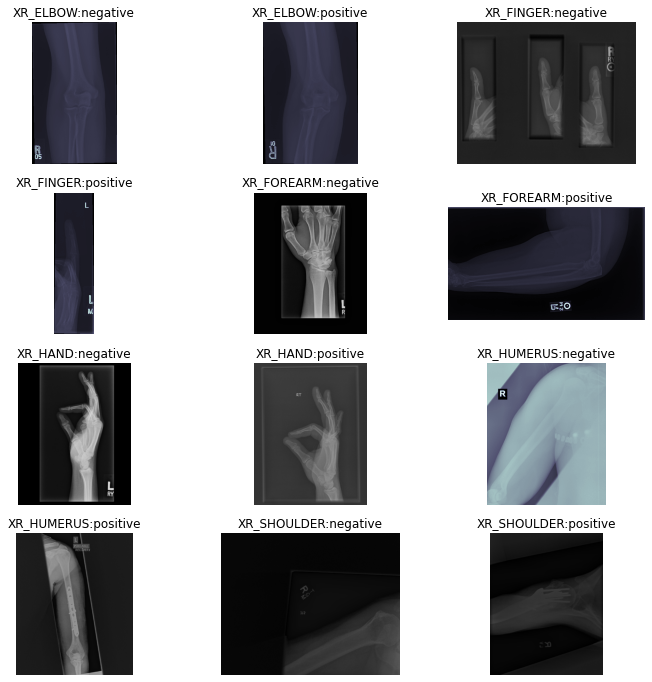

In [30]:
from skimage.io import imread
sub_df = train_images_paths.groupby(['category', 'label']).apply(lambda x: x.sample(1)).reset_index(drop = True)
fig, (m_axs) = plt.subplots(4, sub_df.shape[0]//4, figsize = (12, 12))
for c_ax, (_, c_row) in zip(m_axs.flatten(), sub_df.iterrows()):
    c_ax.imshow(imread(c_row['image_path']), cmap = 'bone')
    c_ax.axis('off')
    c_ax.set_title('{category}:{label}'.format(**c_row))

In [31]:
train, valid = train_test_split(train_images_paths, test_size=0.2,random_state=seed)

In [32]:
test = valid_data_paths.drop(['dir'], axis=1)

## Image Preparing and Pre-Processing

In [33]:
im_size = 256

We wont be doing image augmentations in this notebook , we will do that in other Notebook to see the effect

In [34]:
image_generator_settings = dict(
                          rescale = 1. / 255,
                          #samplewise_center = True,
                          #samplewise_std_normalization = True
                          #rotation_range = 5, 
                         )
image_generator = ImageDataGenerator(**image_generator_settings)

In [35]:
path = 'MURA-v1.1'

In [36]:
train_generator = image_generator.flow_from_dataframe(dataframe = train,directory = None,x_col = 'image_path',y_col = 'label_index',batch_size = 64,shuffle = True,class_mode = 'raw', target_size = (im_size, im_size),color_mode = 'rgb',interpolation='nearest',validate_filenames=False,seed=seed)
valid_generator = image_generator.flow_from_dataframe(dataframe = valid,directory = None,x_col = 'image_path',y_col = 'label_index',batch_size = 64,shuffle = True,class_mode = 'raw',target_size = (im_size, im_size),color_mode = 'rgb',interpolation='nearest',validate_filenames=True,seed=seed)
test_generator = image_generator.flow_from_dataframe(dataframe = test,directory = None,x_col = 'image_path',y_col = 'label_index',batch_size = 64,shuffle = False,class_mode = 'raw', target_size = (im_size, im_size),color_mode = 'rgb',interpolation='nearest', validate_filenames=True,seed=seed)

Found 29446 non-validated image filenames.
Found 7362 validated image filenames.
Found 3197 validated image filenames.


## Initialization

In [37]:
CLASSES = 2
input_shape = (im_size,im_size,3)

### Metrics

In [38]:
def metrics():
    return [
        AUC(name="auc"),
        BinaryAccuracy("accuracy"),
        CohenKappa(name="kappa", num_classes=2)
    ]

### Plotting results

In [39]:
def plot_history(hs, epochs, metric):
    if metric=='loss': 
                label_y = 'Loss'
    elif metric=='accuracy': 
               label_y = 'Accuracy'
    elif metric=='auc': 
               label_y = 'AUC'
    else : label_y = 'kappa'
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel(label_y)
    plt.legend()
    plt.show()

def print_results(model_name,epochs,hs,model_eval):
    print("Train Loss     : {0:.5f}".format(hs.history['loss'][-1]))
    print("Validation Loss: {0:.5f}".format(hs.history['val_loss'][-1]))
    print("Test Loss      : {0:.5f}".format(model_eval[0]))
    print("---")
    print("Train AUC     : {0:.5f}".format(hs.history['auc'][-1]))
    print("Validation AUC: {0:.5f}".format(hs.history['val_auc'][-1]))
    print("Test AUC      : {0:.5f}".format(model_eval[1]))
    print("---")
    print("Train Accuracy     : {0:.5f}".format(hs.history['accuracy'][-1]))
    print("Validation Accuracy: {0:.5f}".format(hs.history['val_accuracy'][-1]))
    print("Test Accuracy      : {0:.5f}".format(model_eval[2]))
    print("---")
    print("Train Kappa     : {0:.5f}".format(hs.history['kappa'][-1]))
    print("Validation Kappa: {0:.5f}".format(hs.history['kappa'][-1]))
    print("Test Kappa      : {0:.5f}".format(model_eval[3]))
    # Plot train and validation error per epoch.
    plot_history(hs={model_name: hs}, epochs=epochs, metric='loss')
    plot_history(hs={model_name: hs}, epochs=epochs, metric='auc')
    plot_history(hs={model_name: hs}, epochs=epochs, metric='accuracy')
    plot_history(hs={model_name: hs}, epochs=epochs, metric='kappa')

### Cleaning up

In [40]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect() #garbage collection
    print("...Finished clean up...")

In [41]:
cd ..

/kaggle/input


In [42]:
def load_all_models_eval():
    for i in range(10):
        os.chdir('/kaggle/input')
        filename = 'mura-models/model_' + str(i + 1) + '.h5'
        print(filename)
        print('>loaded %s' % filename)
        if(i==3):
            model = load_model(filename,compile=False)
            model.compile(optimizer=Adam(),loss= BinaryCrossentropy(from_logits=False),metrics=[metrics()])
        else:
            model = load_model(filename,custom_objects={'metrics':metrics})
        model._name = "Model_Name"+ str(i + 1)
        os.chdir('/kaggle/input/mura-v11')
        model_eval = model.evaluate(test_generator)
        clean_up(model=model)
        clean_up(model=model_eval)
        
    list_model  = ['RESNET50','VGGNET16','VGGNET19']
    for name in list_model:
        os.chdir('/kaggle/input')
        filename = 'mura-models/model_' + name + '.h5'
        print(filename)
        print('>loaded %s' % filename)
        model = load_model(filename,custom_objects={'metrics':metrics})
        model._name = "Model_Name"+ name
        os.chdir('/kaggle/input/mura-v11')
        model_eval = model.evaluate(test_generator)
        clean_up(model=model)
        clean_up(model=model_eval)

In [43]:
load_all_models_eval()

mura-models/model_1.h5
>loaded mura-models/model_1.h5


2022-03-09 13:54:01.030178: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-09 13:54:01.117106: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-09 13:54:01.117853: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-09 13:54:01.118936: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

50/50 [==============================] - 40s 668ms/step - loss: 0.6453 - auc: 0.6953 - accuracy: 0.6228 - kappa: 0.2316
...Finished clean up...
...Finished clean up...
mura-models/model_2.h5
>loaded mura-models/model_2.h5
50/50 [==============================] - 20s 363ms/step - loss: 0.6397 - auc: 0.6976 - accuracy: 0.6484 - kappa: 0.2861
...Finished clean up...
...Finished clean up...
mura-models/model_3.h5
>loaded mura-models/model_3.h5
50/50 [==============================] - 19s 365ms/step - loss: 0.6520 - auc: 0.6944 - accuracy: 0.6365 - kappa: 0.2588
...Finished clean up...
...Finished clean up...
mura-models/model_4.h5
>loaded mura-models/model_4.h5
50/50 [==============================] - 19s 369ms/step - loss: 0.6555 - auc: 0.6854 - accuracy: 0.6325 - kappa: 0.2539
...Finished clean up...
...Finished clean up...
mura-models/model_5.h5
>loaded mura-models/model_5.h5
50/50 [==============================] - 24s 428ms/step - loss: 0.5678 - auc: 0.7833 - accuracy: 0.7163 - kappa:

In [44]:
def ens_all_models_load():
    all_models = list()
    for i in range(10):
        os.chdir('/kaggle/input')
        filename = 'mura-models/model_' + str(i + 1) + '.h5'
        print(filename)
        print('>loaded %s' % filename)
        if(i==3):
            model = load_model(filename,compile=False)
            model.compile(optimizer=Adam(),loss= BinaryCrossentropy(from_logits=False),metrics=[metrics()])
        else:
            model = load_model(filename,custom_objects={'metrics':metrics})
        model._name = "Model_Name"+ str(i + 1)
        os.chdir('/kaggle/input/mura-v11')
        all_models.append(model)
        clean_up(model=model)
        
    list_model  = ['RESNET50','VGGNET16','VGGNET19']
    for name in list_model:
        os.chdir('/kaggle/input')
        filename = 'mura-models/model_' + name + '.h5'
        print(filename)
        print('>loaded %s' % filename)
        model = load_model(filename,custom_objects={'metrics':metrics})
        model._name = "Model_Name"+ name
        os.chdir('/kaggle/input/mura-v11')
        all_models.append(model)
        clean_up(model=model)
        
    return all_models

def ensembleModels(models, model_input,nameip):
    yModels=[model(model_input) for model in models] 
    yAvg=average(yModels) 
    modelEns = Model(inputs=model_input, outputs=yAvg, name=nameip)  
   
    return modelEns

def ens_all_models():
    members = ens_all_models_load()
    print('Loaded %d models' % len(members))
    model_input = Input(shape=input_shape)
    modelEns = ensembleModels(members, model_input,"modelEnsemble")
    return modelEns

In [45]:
from tensorflow.keras.layers import average
modelEns = ens_all_models()

mura-models/model_1.h5
>loaded mura-models/model_1.h5
...Finished clean up...
mura-models/model_2.h5
>loaded mura-models/model_2.h5
...Finished clean up...
mura-models/model_3.h5
>loaded mura-models/model_3.h5
...Finished clean up...
mura-models/model_4.h5
>loaded mura-models/model_4.h5
...Finished clean up...
mura-models/model_5.h5
>loaded mura-models/model_5.h5
...Finished clean up...
mura-models/model_6.h5
>loaded mura-models/model_6.h5
...Finished clean up...
mura-models/model_7.h5
>loaded mura-models/model_7.h5
...Finished clean up...
mura-models/model_8.h5
>loaded mura-models/model_8.h5
...Finished clean up...
mura-models/model_9.h5
>loaded mura-models/model_9.h5
...Finished clean up...
mura-models/model_10.h5
>loaded mura-models/model_10.h5
...Finished clean up...
mura-models/model_RESNET50.h5
>loaded mura-models/model_RESNET50.h5
...Finished clean up...
mura-models/model_VGGNET16.h5
>loaded mura-models/model_VGGNET16.h5
...Finished clean up...
mura-models/model_VGGNET19.h5
>loa

In [46]:
pred_ens = modelEns.predict(test_generator)

In [47]:
cohen_kappa_score((pred_ens> 0.5), test.label_index)

0.48465501769769215

In [48]:
accuracy_score( (pred_ens> 0.5), test.label_index)

0.747263059117923

In [49]:
def ens_all_models_load():
    all_models = list()
    for i in range(10):
        if(i<5):
            continue
        else:
            os.chdir('/kaggle/input')
            filename = 'mura-models/model_' + str(i + 1) + '.h5'
            print(filename)
            print('>loaded %s' % filename)
            if(i==3):
                model = load_model(filename,compile=False)
                model.compile(optimizer=Adam(),loss= BinaryCrossentropy(from_logits=False),metrics=[metrics()])
            else:
                model = load_model(filename,custom_objects={'metrics':metrics})
            model._name = "Model_Name"+ str(i + 1)
            os.chdir('/kaggle/input/mura-v11')
            all_models.append(model)
            clean_up(model=model)
        
    return all_models

def ensembleModels(models, model_input,nameip):
    yModels=[model(model_input) for model in models] 
    yAvg=average(yModels) 
    modelEns = Model(inputs=model_input, outputs=yAvg, name=nameip)  
   
    return modelEns

def ens_all_models():
    members = ens_all_models_load()
    print('Loaded %d models' % len(members))
    model_input = Input(shape=input_shape)
    modelEns = ensembleModels(members, model_input,"modelEnsemble")
    return modelEns

In [50]:
modelEns = ens_all_models()

mura-models/model_6.h5
>loaded mura-models/model_6.h5
...Finished clean up...
mura-models/model_7.h5
>loaded mura-models/model_7.h5
...Finished clean up...
mura-models/model_8.h5
>loaded mura-models/model_8.h5
...Finished clean up...
mura-models/model_9.h5
>loaded mura-models/model_9.h5
...Finished clean up...
mura-models/model_10.h5
>loaded mura-models/model_10.h5
...Finished clean up...
Loaded 5 models


In [51]:
pred_ens = modelEns.predict(test_generator)
cohen_kappa_score((pred_ens> 0.5), test.label_index)
accuracy_score( (pred_ens> 0.5), test.label_index)

0.7697841726618705

In [52]:
def load_all_models7(n_models):
    all_models = list()
    for i in range(n_models):
        filename = 'mura-models/model_XR_SHOULDER_' + str(i + 1) + '.h5'
        print(filename)
        if(i==3):
            model = load_model(filename,compile=False)
            model.compile(optimizer=Adam(),loss= BinaryCrossentropy(from_logits=False),metrics=[metrics()])
        else:
            model = load_model(filename,custom_objects={'metrics':metrics})
        model._name = "Model_Name"+ str(i + 1)
        all_models.append(model)
        clean_up(model=model)
        print('>loaded %s' % filename)          
    return all_models

def load_all_models6(n_models):
    all_models = list()
    for i in range(n_models):
        filename = 'mura-models/model_XR_HUMERUS_' + str(i + 1) + '.h5'
        print(filename)
        if(i==3):
            model = load_model(filename,compile=False)
            model.compile(optimizer=Adam(),loss= BinaryCrossentropy(from_logits=False),metrics=[metrics()])
        else:
            model = load_model(filename,custom_objects={'metrics':metrics})
        model._name = "Model_Name"+ str(i + 1)
        all_models.append(model)
        clean_up(model=model)
        print('>loaded %s' % filename)
    return all_models

def load_all_models5(n_models):
    all_models = list()
    for i in range(n_models):
        filename = 'mura-models/model_XR_FINGER_' + str(i + 1) + '.h5'
        print(filename)
        if(i==3):
            model = load_model(filename,compile=False)
            model.compile(optimizer=Adam(),loss= BinaryCrossentropy(from_logits=False),metrics=[metrics()])
        else:
            model = load_model(filename,custom_objects={'metrics':metrics})
        model._name = "Model_Name"+ str(i + 1)
        all_models.append(model)
        clean_up(model=model)
        print('>loaded %s' % filename)
    return all_models

def load_all_models4(n_models):
    all_models = list()
    for i in range(n_models):
        filename = 'mura-models/model_XR_ELBOW_' + str(i + 1) + '.h5'
        print(filename)
        if(i==3):
            model = load_model(filename,compile=False)
            model.compile(optimizer=Adam(),loss= BinaryCrossentropy(from_logits=False),metrics=[metrics()])
        else:
            model = load_model(filename,custom_objects={'metrics':metrics})
        model._name = "Model_Name"+ str(i + 1)
        all_models.append(model)
        clean_up(model=model)
        print('>loaded %s' % filename)
    return all_models

def load_all_models3(n_models):
    all_models = list()
    for i in range(n_models):
        filename = 'mura-models/model_XR_WRIST_' + str(i + 1) + '.h5'
        print(filename)
        if(i==3):
            model = load_model(filename,compile=False)
            model.compile(optimizer=Adam(),loss= BinaryCrossentropy(from_logits=False),metrics=[metrics()])
        else:
            model = load_model(filename,custom_objects={'metrics':metrics})
        model._name = "Model_Name"+ str(i + 1)
        all_models.append(model)
        clean_up(model=model)
        print('>loaded %s' % filename)
    return all_models

def load_all_models2(n_models):
    all_models = list()
    for i in range(n_models):
        filename = 'mura-models/model_XR_FOREARM_' + str(i + 1) + '.h5'
        print(filename)
        if(i==3):
            model = load_model(filename,compile=False)
            model.compile(optimizer=Adam(),loss= BinaryCrossentropy(from_logits=False),metrics=[metrics()])
        else:
            model = load_model(filename,custom_objects={'metrics':metrics})
        model._name = "Model_Name"+ str(i + 1)
        all_models.append(model)
        clean_up(model=model)
        print('>loaded %s' % filename)
    return all_models

def load_all_models1(n_models):
    all_models = list()
    for i in range(n_models):
        filename = 'mura-models/model_XR_HAND_' + str(i + 1) + '.h5'
        print(filename)
        if(i==3):
            model = load_model(filename,compile=False)
            model.compile(optimizer=Adam(),loss= BinaryCrossentropy(from_logits=False),metrics=[metrics()])
        else:
            model = load_model(filename,custom_objects={'metrics':metrics})
        model._name = "Model_Name"+ str(i + 1)
        all_models.append(model)
        clean_up(model=model)
        print('>loaded %s' % filename)
    return all_models

def load_all_models(n_models):
    all_models = list()
    for i in range(n_models):
        filename = 'mura-models/model_' + str(i + 1) + '.h5'
        print(filename)
        if(i==3):
            model = load_model(filename,compile=False)
            model.compile(optimizer=Adam(),loss= BinaryCrossentropy(from_logits=False),metrics=[metrics()])
        else:
            model = load_model(filename,custom_objects={'metrics':metrics})
        model._name = "Model_Name"+ str(i + 1)
        all_models.append(model)
        clean_up(model=model)
        print('>loaded %s' % filename)
                          
    list_model  = ['RESNET50','VGGNET16','VGGNET19']
    for name in list_model:
        os.chdir('/kaggle/input')
        filename = 'mura-models/model_' + name + '.h5'
        print(filename)
        model = load_model(filename,custom_objects={'metrics':metrics})
        model._name = "Model_Name"+ name
        all_models.append(model)
        clean_up(model=model)
        print('>loaded %s' % filename)

    return all_models

In [53]:
def ensemble_Models(test_generator):
    n_members = 10
    members = load_all_models(n_members)
    print('Loaded %d models' % len(members))
    model_input = Input(shape=input_shape)
    modelEns = ensembleModels(members, model_input,"modelEns")
    
    members = load_all_models1(n_members)
    print('Loaded %d models' % len(members))
    model_input = Input(shape=input_shape)
    modelEnsXR_HAND = ensembleModels(members, model_input,nameip="modelEns1")
    
    members = load_all_models2(n_members)
    print('Loaded %d models' % len(members))
    model_input = Input(shape=input_shape)
    modelEnsXR_FOREARM = ensembleModels(members, model_input,nameip="modelEns2")
    
    members = load_all_models3(n_members)
    print('Loaded %d models' % len(members))
    model_input = Input(shape=input_shape)
    modelEnsXR_WRIST = ensembleModels(members, model_input,nameip="modelEns2")
    
    members = load_all_models4(n_members)
    print('Loaded %d models' % len(members))
    model_input = Input(shape=input_shape)
    modelEnsXR_ELBOW = ensembleModels(members, model_input,nameip="modelEns3")
    
    members = load_all_models5(n_members)
    print('Loaded %d models' % len(members))
    model_input = Input(shape=input_shape)
    modelEnsXR_FINGER = ensembleModels(members, model_input,nameip="modelEns4")
    
    members = load_all_models6(n_members)
    print('Loaded %d models' % len(members))
    model_input = Input(shape=input_shape)
    modelEnsXR_HUMERUS = ensembleModels(members, model_input,nameip="modelEns5")
    
    members = load_all_models7(n_members)
    print('Loaded %d models' % len(members))
    model_input = Input(shape=input_shape)
    modelEnsXR_SHOULDER = ensembleModels(members, model_input,nameip="modelEns6")
 
    output = []
    filename = 'mura-models/model_CAT.h5'
    model = load_model(filename,custom_objects={'metrics':metrics})
    model._name = "Model_Name_CAT"
    os.chdir('/kaggle/input/mura-v11')
    for i in range(50):
        #print(test_generator[i][0].shape)
        batch_img = test_generator[i][0]
       # print(batch_img.shape)
        for j in range(batch_img.shape[0]):
            #print(batch_img[j].shape)
            ind_img = batch_img[j]
            ind_img = ind_img.reshape((1,256,256,3))
            counter = model.predict(ind_img)
            counter_l = np.argmax(counter, axis=1)
            if(counter_l == 0):
                pred_ens = modelEnsXR_HAND.predict(ind_img)
                output.append(pred_ens)
            elif(counter_l == 1):
                pred_ens = modelEnsXR_FOREARM.predict(ind_img)
                output.append(pred_ens)
            elif(counter_l == 2):
                pred_ens = modelEnsXR_WRIST.predict(ind_img)
                output.append(pred_ens)
            elif(counter_l == 3):
                pred_ens = modelEnsXR_ELBOW.predict(ind_img)
                output.append(pred_ens)
            elif(counter_l == 4):
                pred_ens = modelEnsXR_FINGER.predict(ind_img)
                output.append(pred_ens)
            elif(counter_l == 5):
                pred_ens = modelEnsXR_HUMERUS.predict(ind_img)
                output.append(pred_ens)
            elif(counter_l == 6):
                pred_ens = modelEnsXR_SHOULDER.predict(ind_img)
                output.append(pred_ens)
            else:
                pred_ens = modelEns.predict(ind_img)
                output.append(pred_ens)
              
        print("check")
    pred = np.asarray(output)
    return pred

def ensembleModels(models, model_input,nameip):
    yModels=[model(model_input) for model in models] 
    yAvg=average(yModels) 
    modelEns = Model(inputs=model_input, outputs=yAvg, name=nameip)  
   
    return modelEns

In [54]:
cd ..

/kaggle/input


In [55]:
pred_ens = ensemble_Models(test_generator)
pred_ens= pred_ens.squeeze()
print(cohen_kappa_score((pred_ens> 0.5), test.label_index))
print(accuracy_score( (pred_ens> 0.5), test.label_index))

mura-models/model_1.h5
...Finished clean up...
>loaded mura-models/model_1.h5
mura-models/model_2.h5
...Finished clean up...
>loaded mura-models/model_2.h5
mura-models/model_3.h5
...Finished clean up...
>loaded mura-models/model_3.h5
mura-models/model_4.h5
...Finished clean up...
>loaded mura-models/model_4.h5
mura-models/model_5.h5
...Finished clean up...
>loaded mura-models/model_5.h5
mura-models/model_6.h5
...Finished clean up...
>loaded mura-models/model_6.h5
mura-models/model_7.h5
...Finished clean up...
>loaded mura-models/model_7.h5
mura-models/model_8.h5
...Finished clean up...
>loaded mura-models/model_8.h5
mura-models/model_9.h5
...Finished clean up...
>loaded mura-models/model_9.h5
mura-models/model_10.h5
...Finished clean up...
>loaded mura-models/model_10.h5
mura-models/model_RESNET50.h5
...Finished clean up...
>loaded mura-models/model_RESNET50.h5
mura-models/model_VGGNET16.h5
...Finished clean up...
>loaded mura-models/model_VGGNET16.h5
mura-models/model_VGGNET19.h5
...F

In [56]:
cd ..

/kaggle/input


In [57]:
def load_all_models7(n_models):
    all_models = list()
    for i in range(n_models):
        if(i<7):
            continue
        else:
            # define filename for this ensemble
            filename = 'mura-models/model_XR_SHOULDER_' + str(i + 1) + '.h5'
            print(filename)
            # load model from file
            model = load_model(filename,custom_objects={'metrics':metrics})
            model._name = "Model_Name"+ str(i + 1)
            # add to list of members
            all_models.append(model)
            print('>loaded %s' % filename)
    return all_models
def load_all_models6(n_models):
    all_models = list()
    for i in range(n_models):
        if(i<7):
            continue
        else:
            # define filename for this ensemble
            filename = 'mura-models/model_XR_HUMERUS_' + str(i + 1) + '.h5'
            print(filename)
            # load model from file
            model = load_model(filename,custom_objects={'metrics':metrics})
            model._name = "Model_Name"+ str(i + 1)
            # add to list of members
            all_models.append(model)
            print('>loaded %s' % filename)
    return all_models
def load_all_models5(n_models):
    all_models = list()
    for i in range(n_models):
        if(i<7):
            continue
        else:
            # define filename for this ensemble
            filename = 'mura-models/model_XR_FINGER_' + str(i + 1) + '.h5'
            print(filename)
            # load model from file
            model = load_model(filename,custom_objects={'metrics':metrics})
            model._name = "Model_Name"+ str(i + 1)
            # add to list of members
            all_models.append(model)
            print('>loaded %s' % filename)
    return all_models
def load_all_models4(n_models):
    all_models = list()
    for i in range(n_models):
        if(i<7):
            continue
        else:
            # define filename for this ensemble
            filename = 'mura-models/model_XR_ELBOW_' + str(i + 1) + '.h5'
            print(filename)
            # load model from file
            model = load_model(filename,custom_objects={'metrics':metrics})
            model._name = "Model_Name"+ str(i + 1)
            # add to list of members
            all_models.append(model)
            print('>loaded %s' % filename)
    return all_models
def load_all_models3(n_models):
    all_models = list()
    for i in range(n_models):
        if(i<7):
            continue
        else:
            # define filename for this ensemble
            filename = 'mura-models/model_XR_WRIST_' + str(i + 1) + '.h5'
            print(filename)
            # load model from file
            model = load_model(filename,custom_objects={'metrics':metrics})
            model._name = "Model_Name"+ str(i + 1)
            # add to list of members
            all_models.append(model)
            print('>loaded %s' % filename)
    return all_models
def load_all_models2(n_models):
    all_models = list()
    for i in range(n_models):
        if(i<7):
            continue
        else:
            # define filename for this ensemble
            filename = 'mura-models/model_XR_FOREARM_' + str(i + 1) + '.h5'
            print(filename)
            # load model from file
            model = load_model(filename,custom_objects={'metrics':metrics})
            model._name = "Model_Name"+ str(i + 1)
            # add to list of members
            all_models.append(model)
            print('>loaded %s' % filename)
    return all_models
def load_all_models1(n_models):
    all_models = list()
    for i in range(n_models):
        if(i<7):
            continue
        else:
            # define filename for this ensemble
            filename = 'mura-models/model_XR_HAND_' + str(i + 1) + '.h5'
            print(filename)
            # load model from file
            model = load_model(filename,custom_objects={'metrics':metrics})
            model._name = "Model_Name"+ str(i + 1)
            # add to list of members
            all_models.append(model)
            print('>loaded %s' % filename)
    return all_models
def load_all_models(n_models):
    all_models = list()
    for i in range(n_models):
        if(i<7):
            continue
        else:
            # define filename for this ensemble
            filename = 'mura-models/model_' + str(i + 1) + '.h5'
            print(filename)
            # load model from file
            model = load_model(filename,custom_objects={'metrics':metrics})
            model._name = "Model_Name"+ str(i + 1)
            # add to list of members
            all_models.append(model)
            print('>loaded %s' % filename)
    return all_models

In [58]:
pred_ens = ensemble_Models(test_generator)
pred_ens= pred_ens.squeeze()
print(cohen_kappa_score((pred_ens> 0.5), test.label_index))
print(accuracy_score( (pred_ens> 0.5), test.label_index))

mura-models/model_8.h5
>loaded mura-models/model_8.h5
mura-models/model_9.h5
>loaded mura-models/model_9.h5
mura-models/model_10.h5
>loaded mura-models/model_10.h5
Loaded 3 models
mura-models/model_XR_HAND_8.h5
>loaded mura-models/model_XR_HAND_8.h5
mura-models/model_XR_HAND_9.h5
>loaded mura-models/model_XR_HAND_9.h5
mura-models/model_XR_HAND_10.h5
>loaded mura-models/model_XR_HAND_10.h5
Loaded 3 models
mura-models/model_XR_FOREARM_8.h5
>loaded mura-models/model_XR_FOREARM_8.h5
mura-models/model_XR_FOREARM_9.h5
>loaded mura-models/model_XR_FOREARM_9.h5
mura-models/model_XR_FOREARM_10.h5
>loaded mura-models/model_XR_FOREARM_10.h5
Loaded 3 models
mura-models/model_XR_WRIST_8.h5
>loaded mura-models/model_XR_WRIST_8.h5
mura-models/model_XR_WRIST_9.h5
>loaded mura-models/model_XR_WRIST_9.h5
mura-models/model_XR_WRIST_10.h5
>loaded mura-models/model_XR_WRIST_10.h5
Loaded 3 models
mura-models/model_XR_ELBOW_8.h5
>loaded mura-models/model_XR_ELBOW_8.h5
mura-models/model_XR_ELBOW_9.h5
>loaded 